In [1]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm
import seaborn as sns
import os
import pickle
sns.set_style("dark")
from utils import *

In [2]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = '../charts/custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['load_based_advanced_barabasi', 'load_based_simple_barabasi', 'load_based_advanced_lobster', 'load_based_simple_lobster']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 359
# time management
minTime = 60
maxTime = 3600
timeColumnName = 'time'
logarithmicTime = False
excludeVariables = []
# One or more variables are considered random and "flattened"
seedVars = ['random']
# Label mapping

In [3]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file, excludeVariables))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            print(dimensions)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file, excludeVariables)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }

# QoS Analysis for load balancing scenario

## Lobster network

In [4]:
simple_dataset = means['load_based_simple_lobster']
advanced_dataset = means['load_based_advanced_lobster']

Extract the `QoS` from the two dataset generated above by dividing `canOffload` with `wantToOffload`

In [5]:
qos_simple = simple_dataset[
    { "canOffload[sum]", "wantToOffload[sum]", "devices" }
].mean(dim = { "leaders" }, skipna = True)
qos_simple = qos_simple.assign(qos_simple=lambda x: x["canOffload[sum]"] / x["wantToOffload[sum]"])

qos_advanced = advanced_dataset[
    { "canOffload[sum]", "wantToOffload[sum]", "devices" }
].mean(dim = { "leaders" }, skipna = True)
qos_advanced = qos_advanced.assign(qos_advanced=lambda x: x["canOffload[sum]"] / x["wantToOffload[sum]"])

In [6]:
combined = xr.combine_by_coords([qos_advanced.qos_advanced, qos_simple.qos_simple])
combined

<xarray.Dataset>
Dimensions:            (devices: 3, computationalCost: 3, time: 359)
Coordinates:
  * devices            (devices) float64 100.0 150.0 200.0
  * computationalCost  (computationalCost) float64 1.0 3.0 10.0
  * time               (time) float64 60.0 69.89 79.78 ... 3.59e+03 3.6e+03
Data variables:
    qos_advanced       (computationalCost, devices, time) float64 0.9828 ... ...
    qos_simple         (computationalCost, devices, time) float64 1.0 ... 0.1299

## With computational cost 1%

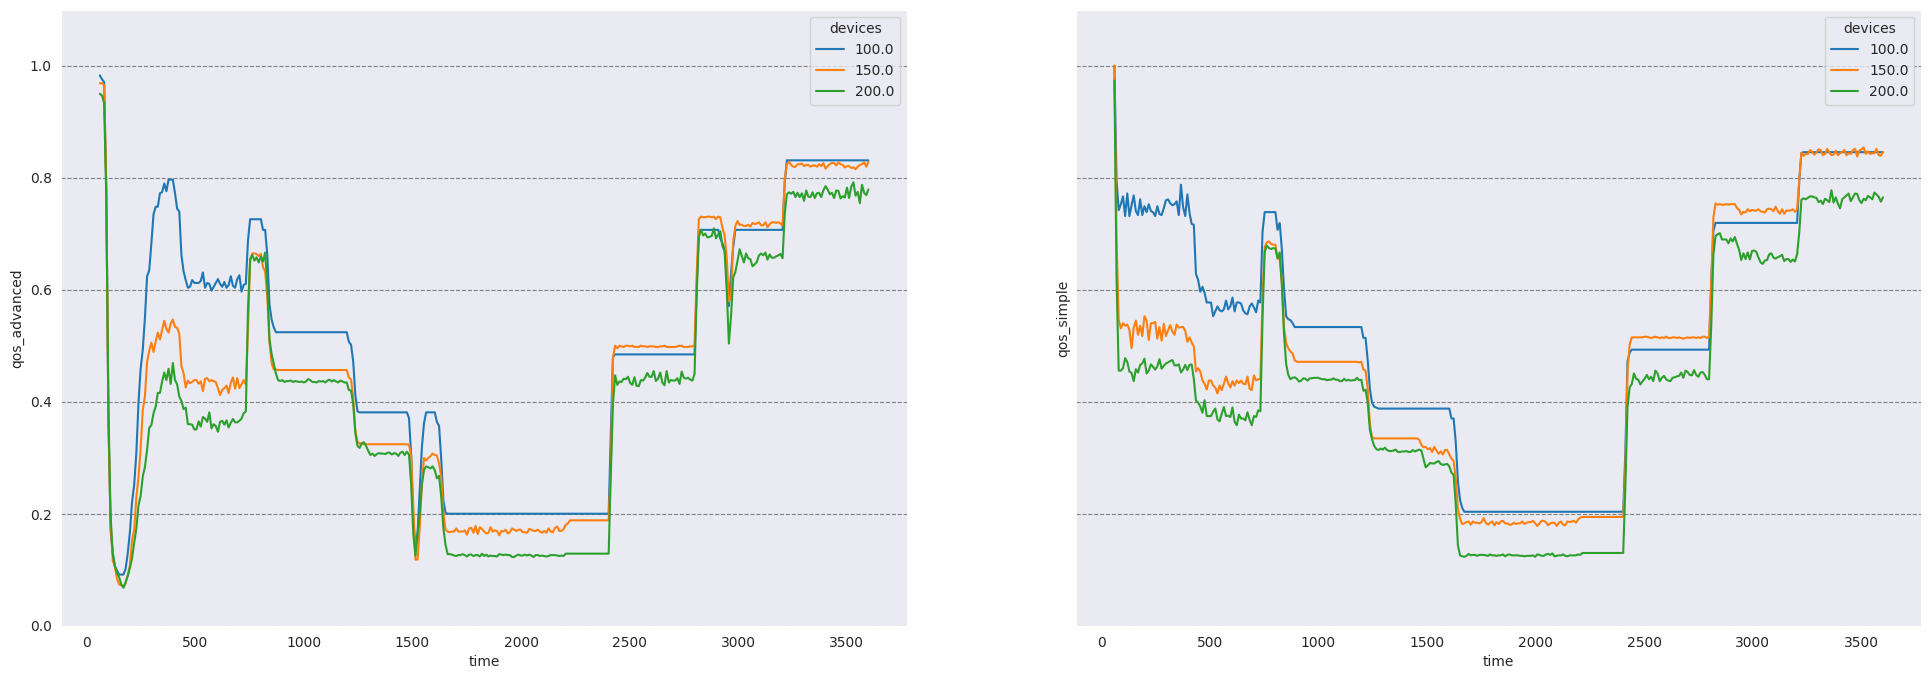

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[0], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 1.1))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[0], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 1.1))

# advanced_data = qos_advanced.qos_advanced
# advanced_data.isel(computationalCost=[0, 1, 2]).plot.line(x="time", ylim=(0, 1.1))

In [8]:
advanced_mean_1_100 = advanced_data.isel(computationalCost=[0], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_100 = simple_data.isel(computationalCost=[0], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_100 = (advanced_mean_1_100 - simple_mean_1_100) / simple_mean_1_100 * 100

advanced_mean_1_150 = advanced_data.isel(computationalCost=[0], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_150 = simple_data.isel(computationalCost=[0], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_150 = (advanced_mean_1_150 - simple_mean_1_150) / simple_mean_1_150 * 100

advanced_mean_1_200 = advanced_data.isel(computationalCost=[0], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_200 = simple_data.isel(computationalCost=[0], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_200 = (advanced_mean_1_200 - simple_mean_1_200) / simple_mean_1_200 * 100

print("Advanced load-balancing with 1% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_1_100))
print("Advanced load-balancing with 1% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_1_150))
print("Advanced load-balancing with 1% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_1_200))

Advanced load-balancing with 1% of load cost and 100 devices outperforms: -6.066%
Advanced load-balancing with 1% of load cost and 150 devices outperforms: -6.460%
Advanced load-balancing with 1% of load cost and 200 devices outperforms: -4.184%


## With computational cost 3%

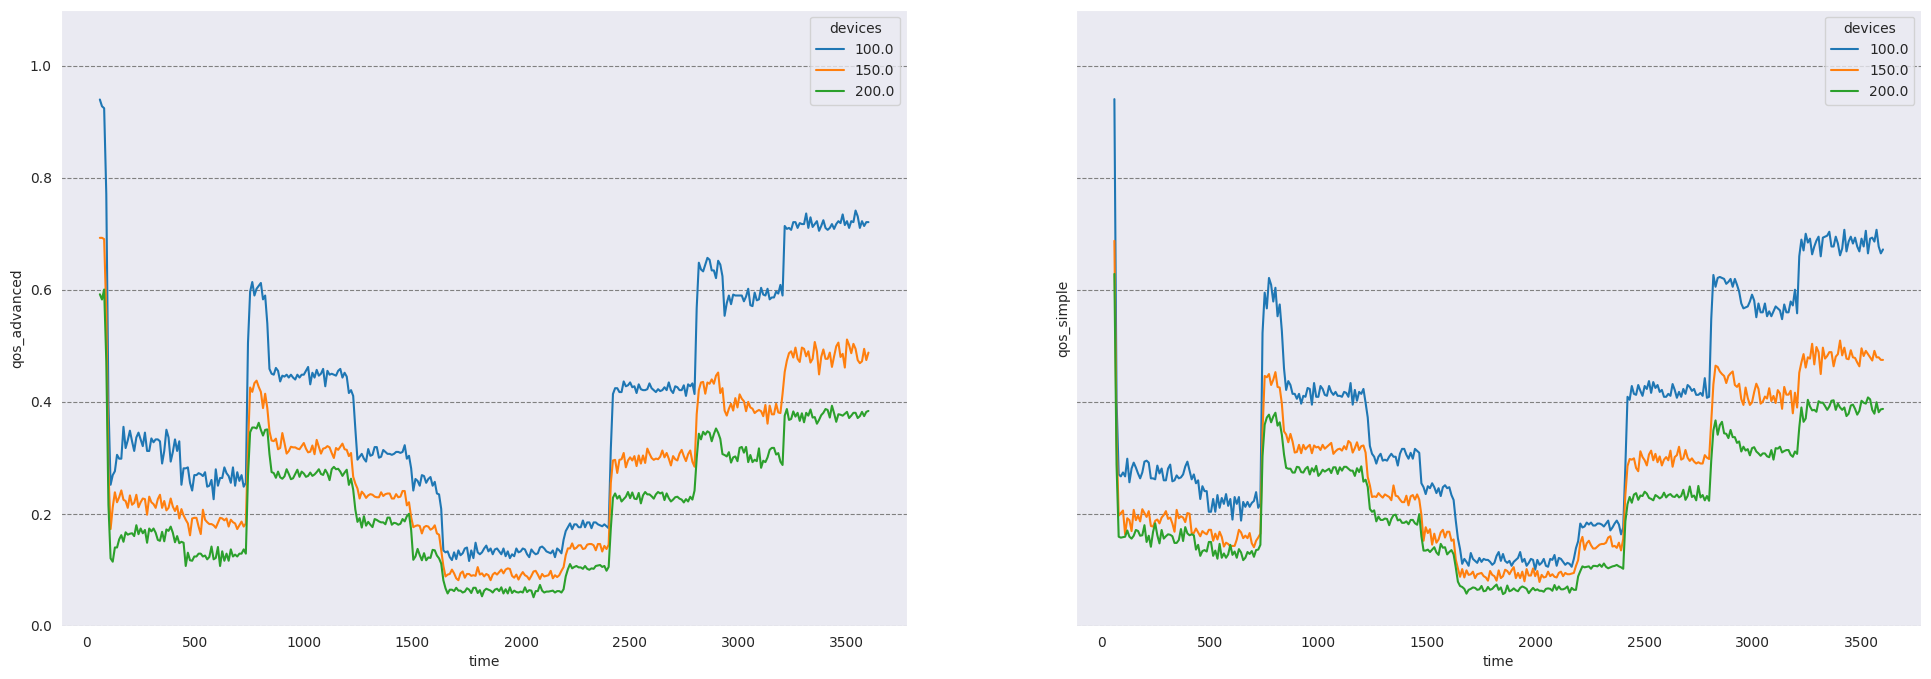

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[1], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 1.1))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[1], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 1.1))

In [10]:
advanced_mean_3_100 = advanced_data.isel(computationalCost=[1], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_100 = simple_data.isel(computationalCost=[1], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_100 = (advanced_mean_3_100 - simple_mean_3_100) / simple_mean_3_100 * 100

advanced_mean_3_150 = advanced_data.isel(computationalCost=[1], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_150 = simple_data.isel(computationalCost=[1], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_150 = (advanced_mean_3_150 - simple_mean_3_150) / simple_mean_3_150 * 100

advanced_mean_3_200 = advanced_data.isel(computationalCost=[1], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_200 = simple_data.isel(computationalCost=[1], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_200 = (advanced_mean_3_200 - simple_mean_3_200) / simple_mean_3_200 * 100

print("Advanced load-balancing with 3% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_3_100))
print("Advanced load-balancing with 3% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_3_150))
print("Advanced load-balancing with 1% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_3_200))

Advanced load-balancing with 3% of load cost and 100 devices outperforms: 7.334%
Advanced load-balancing with 3% of load cost and 150 devices outperforms: 2.679%
Advanced load-balancing with 1% of load cost and 200 devices outperforms: -1.006%


## With computational cost 10%

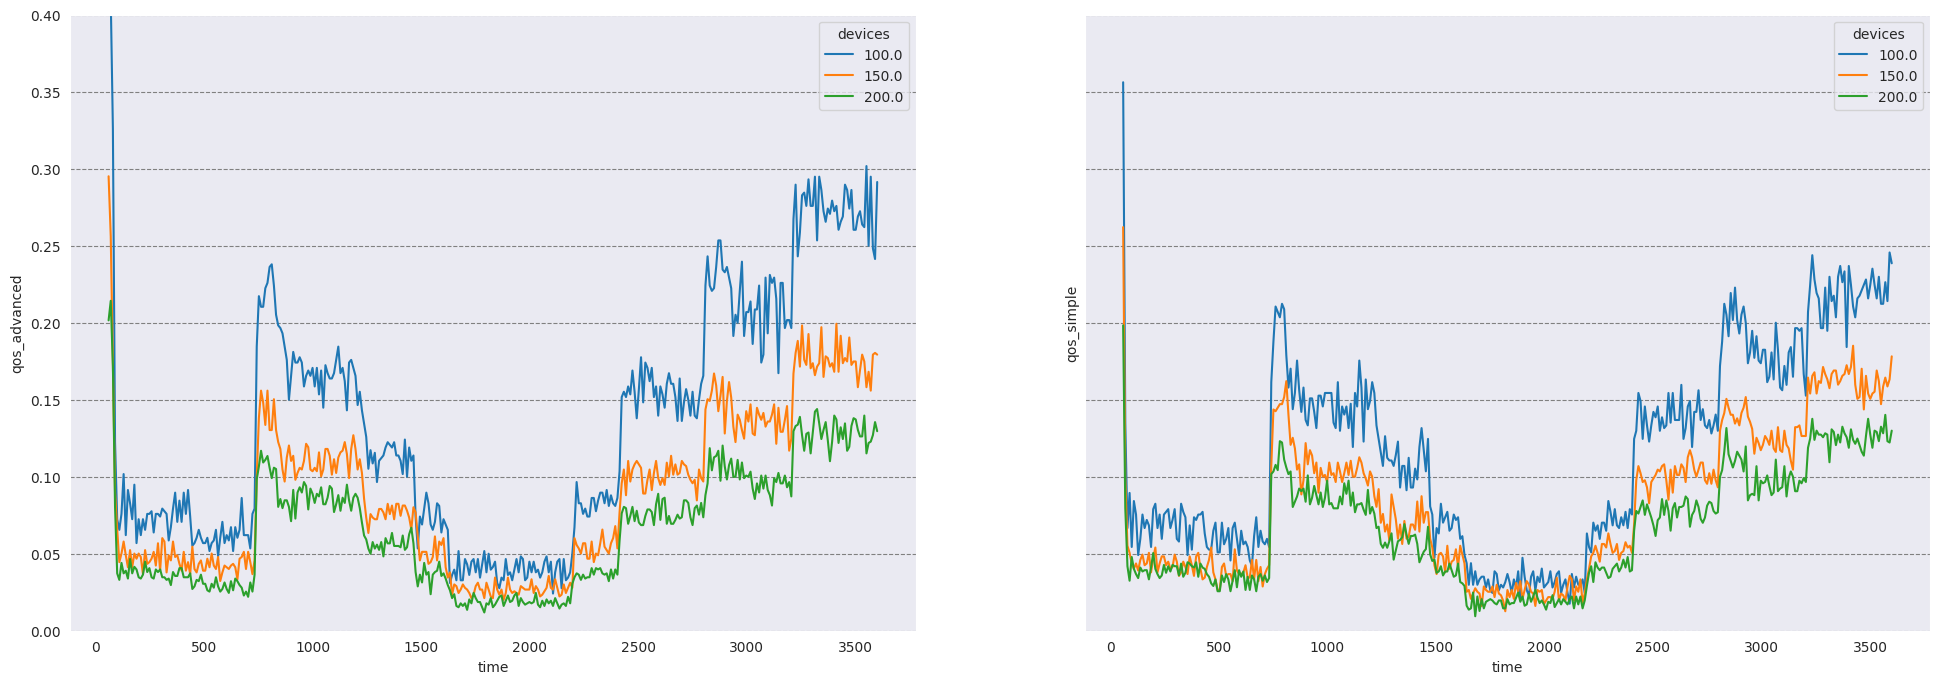

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[2], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 0.4))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[2], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 0.4))

In [12]:
advanced_mean_10_100 = advanced_data.isel(computationalCost=[2], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_100 = simple_data.isel(computationalCost=[2], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_100 = (advanced_mean_10_100 - simple_mean_10_100) / simple_mean_10_100 * 100

advanced_mean_10_150 = advanced_data.isel(computationalCost=[2], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_150 = simple_data.isel(computationalCost=[2], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_150 = (advanced_mean_10_150 - simple_mean_10_150) / simple_mean_10_150 * 100

advanced_mean_10_200 = advanced_data.isel(computationalCost=[2], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_200 = simple_data.isel(computationalCost=[2], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_200 = (advanced_mean_10_200 - simple_mean_10_200) / simple_mean_10_200 * 100

print("Advanced load-balancing with 10% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_10_100))
print("Advanced load-balancing with 10% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_10_150))
print("Advanced load-balancing with 10% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_10_200))

Advanced load-balancing with 10% of load cost and 100 devices outperforms: 16.644%
Advanced load-balancing with 10% of load cost and 150 devices outperforms: 7.501%
Advanced load-balancing with 10% of load cost and 200 devices outperforms: 0.005%


## Barabasi network

In [13]:
simple_dataset = means['load_based_simple_barabasi']
advanced_dataset = means['load_based_advanced_barabasi']

In [14]:
qos_simple = simple_dataset[
    { "canOffload[sum]", "wantToOffload[sum]", "devices" }
].mean(dim = { "leaders" }, skipna = True)
qos_simple = qos_simple.assign(qos_simple=lambda x: x["canOffload[sum]"] / x["wantToOffload[sum]"])

qos_advanced = advanced_dataset[
    { "canOffload[sum]", "wantToOffload[sum]", "devices" }
].mean(dim = { "leaders" }, skipna = True)
qos_advanced = qos_advanced.assign(qos_advanced=lambda x: x["canOffload[sum]"] / x["wantToOffload[sum]"])

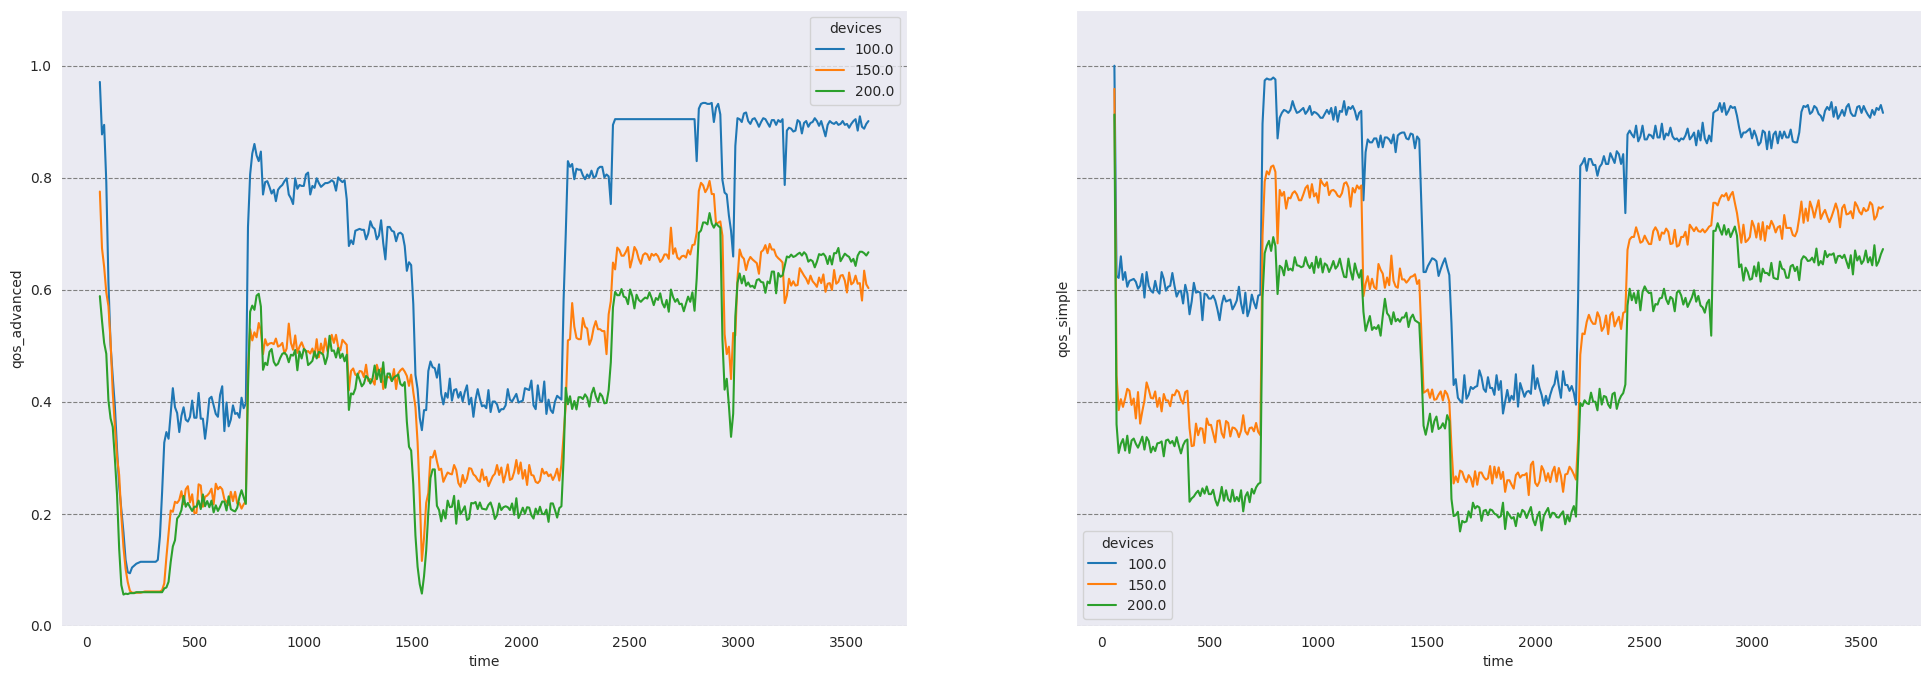

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[0], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 1.1))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[0], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 1.1))

# advanced_data = qos_advanced.qos_advanced
# advanced_data.isel(computationalCost=[0, 1, 2]).plot.line(x="time", ylim=(0, 1.1))

In [16]:
advanced_mean_1_100 = advanced_data.isel(computationalCost=[0], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_100 = simple_data.isel(computationalCost=[0], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_100 = (advanced_mean_1_100 - simple_mean_1_100) / simple_mean_1_100 * 100

advanced_mean_1_150 = advanced_data.isel(computationalCost=[0], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_150 = simple_data.isel(computationalCost=[0], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_150 = (advanced_mean_1_150 - simple_mean_1_150) / simple_mean_1_150 * 100

advanced_mean_1_200 = advanced_data.isel(computationalCost=[0], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_1_200 = simple_data.isel(computationalCost=[0], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_1_200 = (advanced_mean_1_200 - simple_mean_1_200) / simple_mean_1_200 * 100

print("Advanced load-balancing with 1% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_1_100))
print("Advanced load-balancing with 1% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_1_150))
print("Advanced load-balancing with 1% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_1_200))

Advanced load-balancing with 1% of load cost and 100 devices outperforms: -12.254%
Advanced load-balancing with 1% of load cost and 150 devices outperforms: -19.707%
Advanced load-balancing with 1% of load cost and 200 devices outperforms: -12.142%


## With computational cost 3%

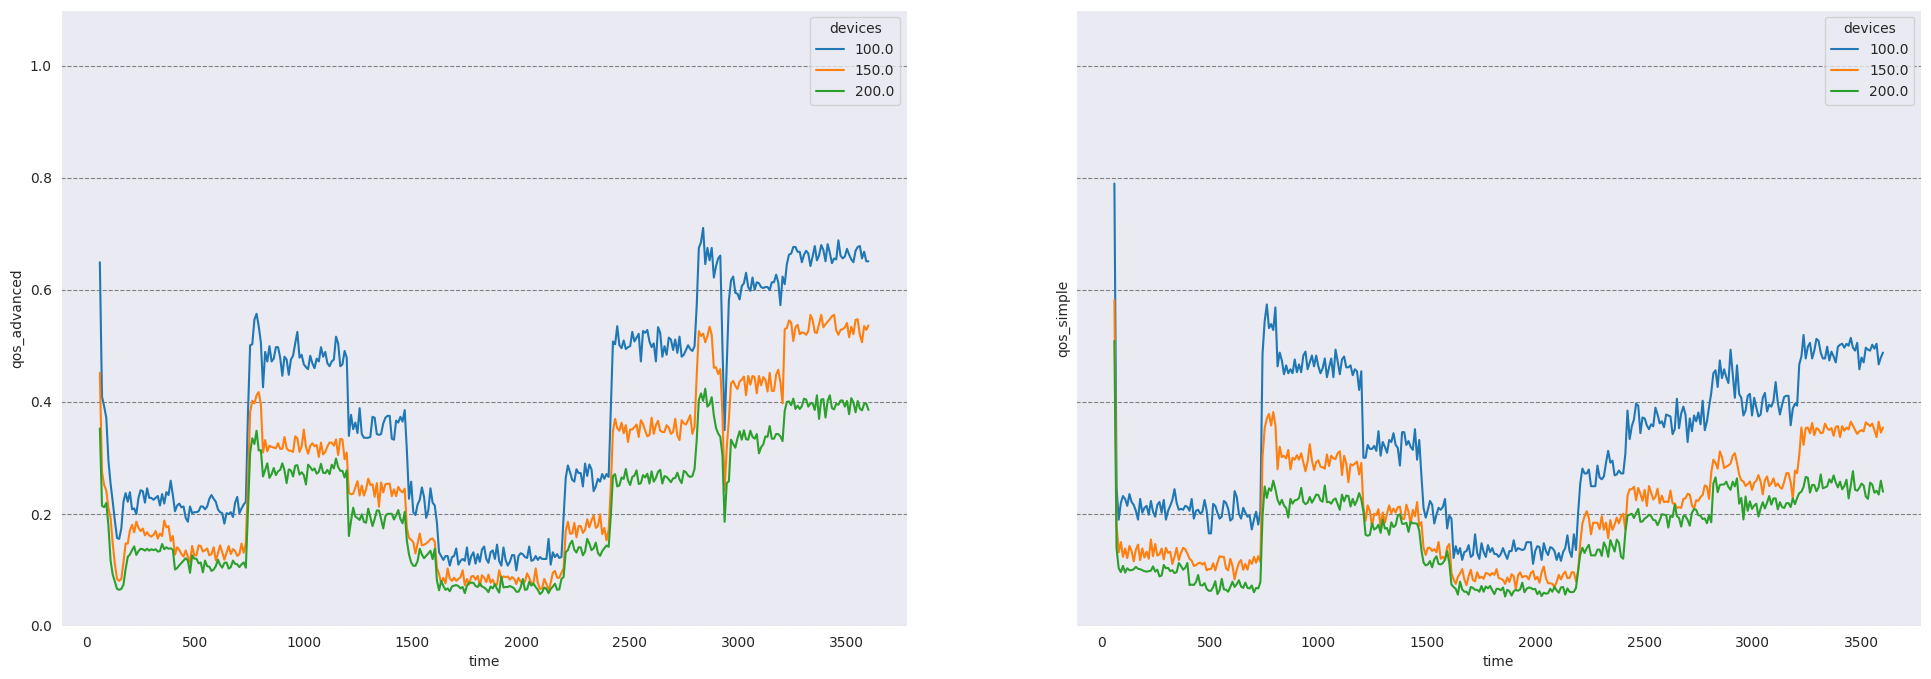

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[1], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 1.1))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[1], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 1.1))

In [18]:
advanced_mean_3_100 = advanced_data.isel(computationalCost=[1], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_100 = simple_data.isel(computationalCost=[1], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_100 = (advanced_mean_3_100 - simple_mean_3_100) / simple_mean_3_100 * 100

advanced_mean_3_150 = advanced_data.isel(computationalCost=[1], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_150 = simple_data.isel(computationalCost=[1], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_150 = (advanced_mean_3_150 - simple_mean_3_150) / simple_mean_3_150 * 100

advanced_mean_3_200 = advanced_data.isel(computationalCost=[1], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_3_200 = simple_data.isel(computationalCost=[1], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_3_200 = (advanced_mean_3_200 - simple_mean_3_200) / simple_mean_3_200 * 100

print("Advanced load-balancing with 3% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_3_100))
print("Advanced load-balancing with 3% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_3_150))
print("Advanced load-balancing with 1% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_3_200))

Advanced load-balancing with 3% of load cost and 100 devices outperforms: 19.259%
Advanced load-balancing with 3% of load cost and 150 devices outperforms: 31.651%
Advanced load-balancing with 1% of load cost and 200 devices outperforms: 33.184%


## With computational cost 10%

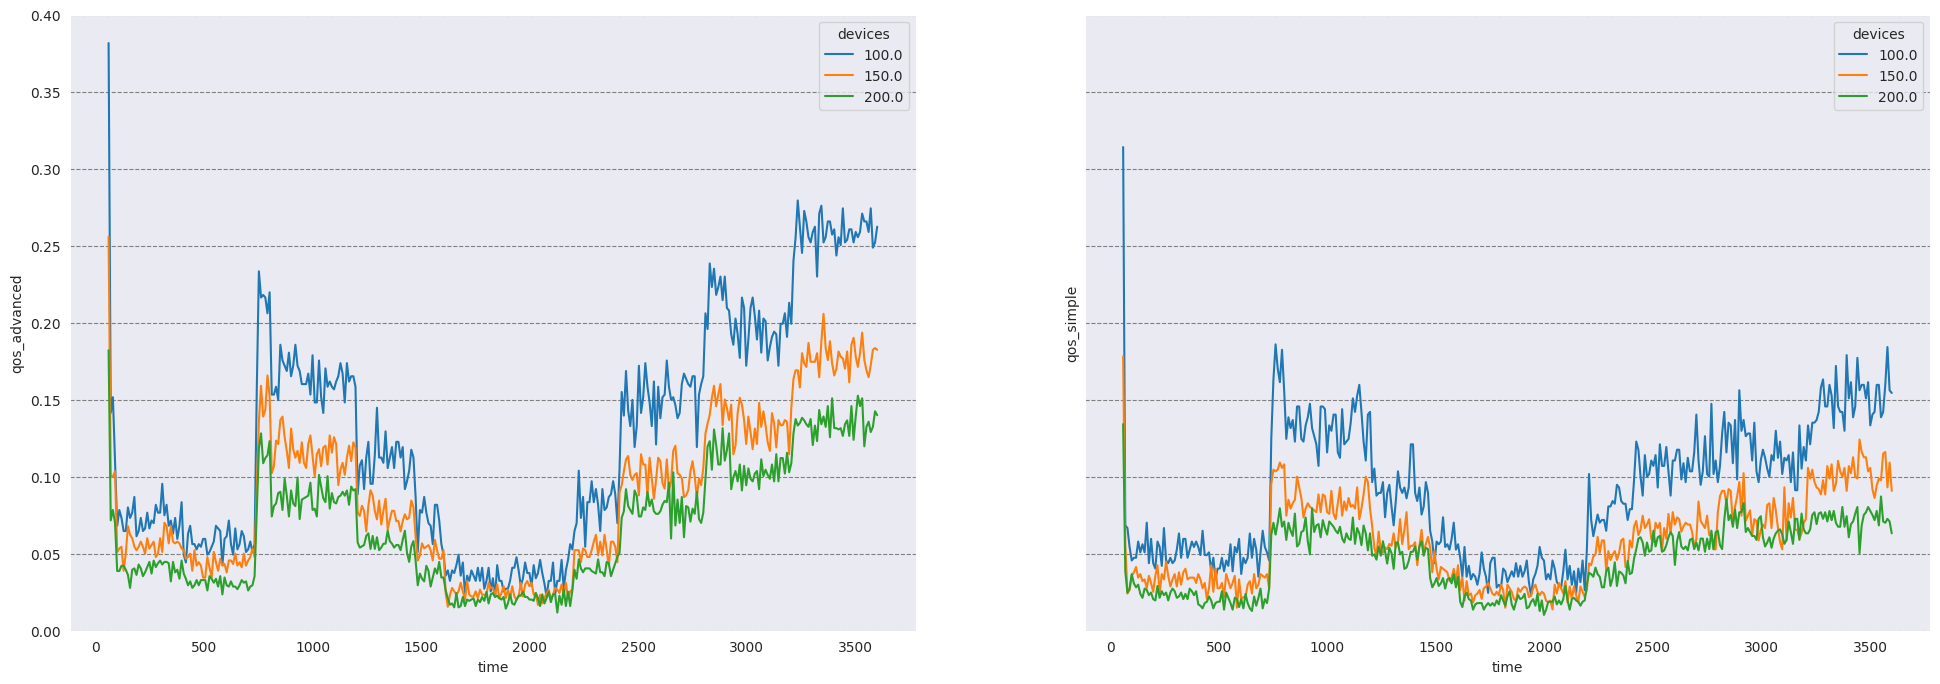

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')

advanced_data = qos_advanced.qos_advanced
advanced_data.isel(computationalCost=[2], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax1, x="time", ylim=(0, 0.4))

simple_data = qos_simple.qos_simple
simple_data.isel(computationalCost=[2], devices=[0, 1, 2]).mean(dim={'computationalCost'}).plot.line(ax=ax2, x="time", ylim=(0, 0.4))

In [20]:
advanced_mean_10_100 = advanced_data.isel(computationalCost=[2], devices=[0]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_100 = simple_data.isel(computationalCost=[2], devices=[0]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_100 = (advanced_mean_10_100 - simple_mean_10_100) / simple_mean_10_100 * 100

advanced_mean_10_150 = advanced_data.isel(computationalCost=[2], devices=[1]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_150 = simple_data.isel(computationalCost=[2], devices=[1]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_150 = (advanced_mean_10_150 - simple_mean_10_150) / simple_mean_10_150 * 100

advanced_mean_10_200 = advanced_data.isel(computationalCost=[2], devices=[2]).mean(dim={'computationalCost'}).mean().values
simple_mean_10_200 = simple_data.isel(computationalCost=[2], devices=[2]).mean(dim={'computationalCost'}).mean().values
percentage_variation_10_200 = (advanced_mean_10_200 - simple_mean_10_200) / simple_mean_10_200 * 100

print("Advanced load-balancing with 10% of load cost and 100 devices outperforms: {:.3f}%".format(percentage_variation_10_100))
print("Advanced load-balancing with 10% of load cost and 150 devices outperforms: {:.3f}%".format(percentage_variation_10_150))
print("Advanced load-balancing with 10% of load cost and 200 devices outperforms: {:.3f}%".format(percentage_variation_10_200))

Advanced load-balancing with 10% of load cost and 100 devices outperforms: 39.766%
Advanced load-balancing with 10% of load cost and 150 devices outperforms: 50.581%
Advanced load-balancing with 10% of load cost and 200 devices outperforms: 47.675%
